## First lets see what regret looks like for each of the meta experts, (should be sublinear)

## Generate synth data, Anh with ridge meta experts, then check each experts loss

In [1]:
import os
os.chdir('..')
from bilevel.synth_datagen import SynthGenLinear
!pwd

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
        'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False, 
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[7 0 5 3 1 2 4 6] ['native-am' 'male' 'some-other' 'black' 'female' 'white' 'two-or-more'
 'asian']


In [4]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more',
       'g_some-other', 'g_asian', 'g_native-am', 'y_male', 'y_female',
       'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian',
       'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active',
       'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_male', 'y_female', 'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian', 'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more', 'g_some-other', 'g_asian', 'g_native-am']


In [5]:
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.build_all_models import *

In [8]:
def get_all_aggregations_linear(df, filter_x, l2_pen = 0.0):
    # y_lab_list = ['y_dperm_active', 'y_mean_active', 'y_min_active', 'y_max_active']
    y_lab_list = ['y_min_active']
    X_dat = df[filter_x]
    X_dat = numeric_scaler(X_dat, X_dat.columns)
    A_t = syn_ob.A_t
    baseline_dict = dict.fromkeys(y_lab_list)
    Anh_dict = dict.fromkeys(y_lab_list)
    for y_lab in y_lab_list:
        y_dat = df[[y_lab]]
        y_dat = numeric_scaler(y_dat, y_dat.columns)
        y_dat = y_dat[y_lab]
        dirname_baseline = './synthetic_res_models/baseline'
        filename = 'aggregated_0-1x_w0-1' + y_lab
        baseline_dict[y_lab] = build_baseline_alwayson(dirname_baseline, filename, A_t, OnlineLinearExpert(X_dat, y_dat, l2_pen = l2_pen))
        dirname_Anh = './synthetic_res_models/Anh/'
        Anh_dict[y_lab] = build_Anh(dirname_Anh, filename, A_t, [OnlineLinearExpert(X_dat, y_dat, l2_pen = l2_pen) for _ in range(A_t.shape[1])])
    return baseline_dict, Anh_dict

def barplot_aggregations(baseline_dict, Anh_dict):
    A_t = syn_ob.A_t
    for y_lab in baseline_dict.keys():
       base_ends = [baseline_dict[y_lab].expert.cumloss_groupwise[g][-1] for g in range(A_t.shape[1])]
       Anh_ends = [Anh_dict[y_lab].Anh.cumloss_groupwise_ada[g][-1] for g in range(A_t.shape[1])]
       ind = np.arange(1, A_t.shape[1]+1)
       plt.bar(ind,  base_ends)
       plt.bar(ind, Anh_ends)
       plt.title(y_lab)
       plt.show()

def baseline_vs_Anh_printagg(baseline_dict, Anh_dict):
    A_t = syn_ob.A_t
    for y_lab in baseline_dict.keys():
       active_rounds = [len(baseline_dict[y_lab].expert.cumloss_groupwise[g]) for g in range(A_t.shape[1])]
       base_ends = [baseline_dict[y_lab].expert.cumloss_groupwise[g][-1] for g in range(A_t.shape[1])]
       Anh_ends = [Anh_dict[y_lab].Anh.cumloss_groupwise_ada[g][-1] for g in range(A_t.shape[1])]
       print(y_lab)
       print("Active", active_rounds)
       print("Base:", base_ends)
       print("Anh:", Anh_ends)
       print("---------------")

In [ ]:
# try with Ridge experts l2_pen = 1
baseline_dict_ridge, Anh_dict_ridge = get_all_aggregations_linear(df, filter_feature+filter_group, l2_pen = 1.0)


y_min_active
Active [49881, 50119, 61118, 12105, 9904, 8002, 5940, 2931]
Base: [650.9412128250249, 482.94578231702013, 562.1054321763129, 161.16397222638435, 159.78567296952403, 122.18631438507303, 89.54064981729059, 39.104953567456384]
Anh: [496.66528410662255, 456.641445230895, 501.62764886707026, 137.13744465204533, 119.71607525246608, 94.37003674962429, 69.6849918436023, 30.770531972706415]
---------------


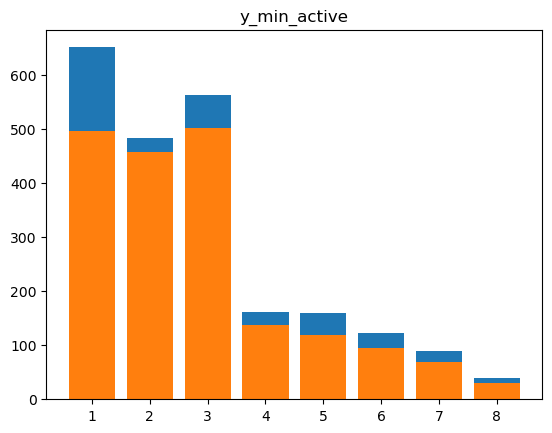

In [9]:
baseline_vs_Anh_printagg(baseline_dict_ridge, Anh_dict_ridge)
barplot_aggregations(baseline_dict_ridge, Anh_dict_ridge)

100%|██████████| 100000/100000 [02:48<00:00, 594.52it/s]


y_min_active
Active [49915, 50085, 61153, 11924, 9797, 7995, 6115, 3016]
Base: [188.00160768258579, 160.78856541180673, 198.97322275767945, 45.33272578400134, 38.7931016525606, 31.261462368522043, 23.88361034253829, 10.546050189087863]
Anh: [111.00406377261078, 81.50010191068851, 120.89979502438958, 19.754599566619326, 17.19917443038195, 14.015047474220713, 13.488112784817094, 7.147436402870997]
---------------


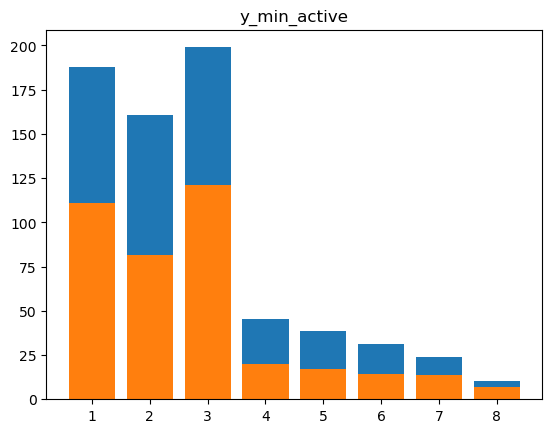

In [14]:
# try with Ridge experts l2_pen = 1
baseline_dict_ls, Anh_dict_ls = get_all_aggregations_linear(df, filter_feature+filter_group, l2_pen = 0.0)
baseline_vs_Anh_printagg(baseline_dict_ls, Anh_dict_ls)
barplot_aggregations(baseline_dict_ls, Anh_dict_ls)

In [10]:
Anhrm = Anh_dict_ridge['y_min_active'].Anh # Anh ridge meta experts
Anhrm.A_t, Anhrm.loss_ada_t_arr.shape, Anhrm.l_t.shape

(array([[1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]]),
 (100000,),
 (100000, 8))

## Sanity checks
 1. check if Anh - its ridge meta experts loss is like $\sqrt{T_g}$ Yes!
 2. ridge meta expert - best in hindsights loss is like $||\theta||^2 + \log{(T_g+1)}$ 

In [35]:
# Anhrm.cuml_loss_curve
Anhdiffmeta = np.cumsum(Anhrm.loss_ada_t_arr.reshape(-1,1) * Anhrm.A_t, axis=0) - np.cumsum(Anhrm.l_t, axis=0)
Anhdiffmeta.shape

(100000, 8)

In [12]:
np.sum(Anhrm.A_t, axis=0)

array([49881., 50119., 61118., 12105.,  9904.,  8002.,  5940.,  2931.])

### 1 Anh - its ridge meta experts loss

49881 (49881,) (49881,)


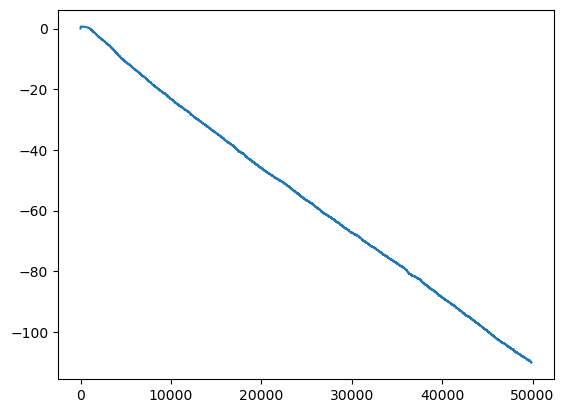

50119 (50119,) (50119,)


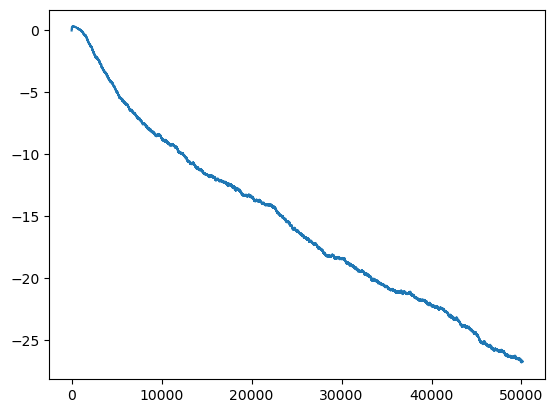

61118 (61118,) (61118,)


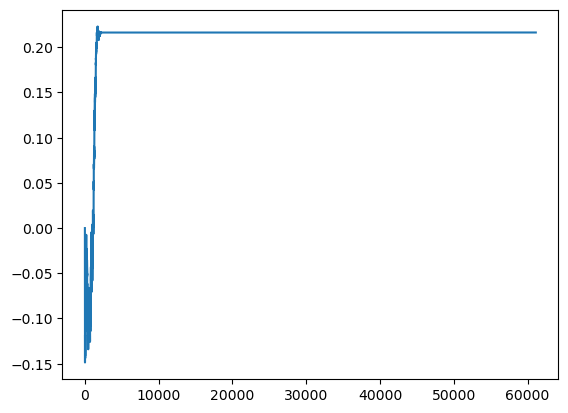

12105 (12105,) (12105,)


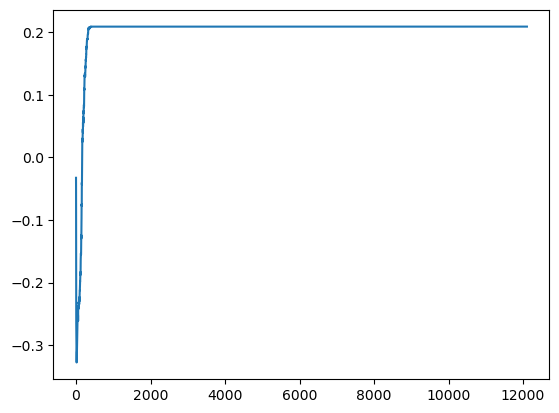

9904 (9904,) (9904,)


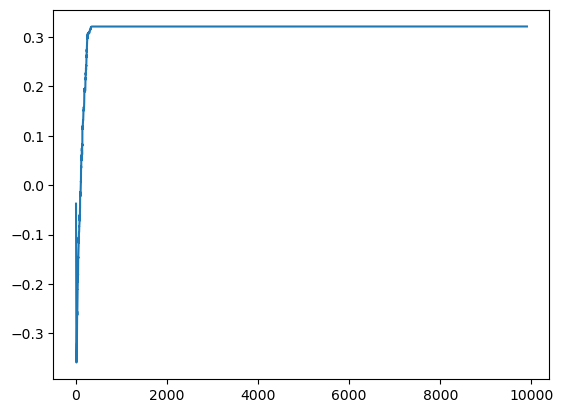

8002 (8002,) (8002,)


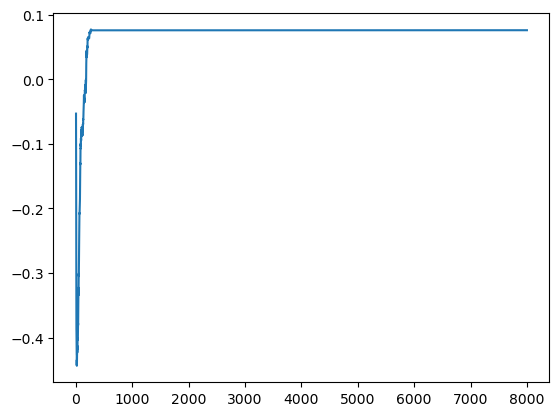

5940 (5940,) (5940,)


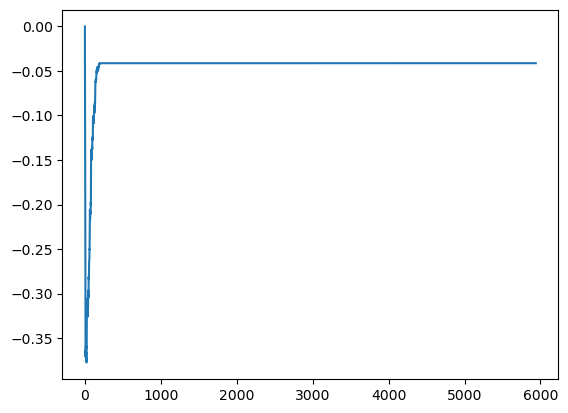

2931 (2931,) (2931,)


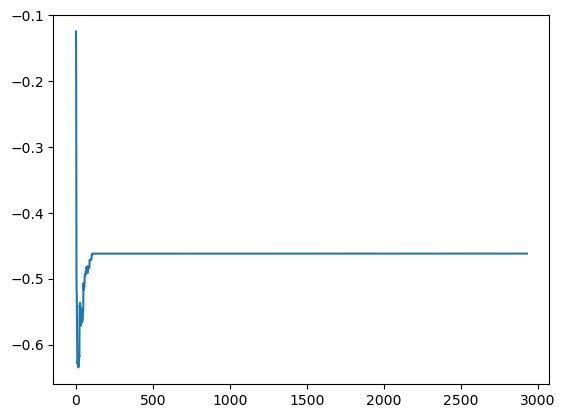

In [14]:
T = Anhrm.A_t.shape[0]
N = Anhrm.A_t.shape[1]
diffAnhmeta = []
for gnum in range(N):
    T_g = len(Anhrm.cumloss_groupwise_ada[gnum])
    print(T_g, Anhrm.cumloss_groupwise_ada[gnum].shape, Anhrm.cumloss_groupwise_metaexp[gnum].shape)
    diffAnhmeta.append(Anhrm.cumloss_groupwise_ada[gnum] - Anhrm.cumloss_groupwise_metaexp[gnum])
    plt.plot(np.arange(T_g), diffAnhmeta[-1])
    # plt.plot(np.arange(T_g), np.arange(T_g)**0.5)
    plt.show()

In [15]:
Anhrm.cumloss_groupwise_ada[0]

array([2.24422448e-01, 5.95710524e-01, 7.42602192e-01, ...,
       4.96659266e+02, 4.96660461e+02, 4.96665284e+02])

In [23]:
for gnum in range(8):
    a = Anhrm.cumloss_groupwise_ada[gnum]
    print(gnum, np.all(a[:-1] <= a[1:]))

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True


In [26]:
printlen(Anhrm.experts)

8

### 2. ridge meta expert - best in hindsight loss

In [58]:
cl_group_metaexp = Anhrm.cumloss_groupwise_metaexp

In [139]:
from sklearn.linear_model import LinearRegression

def find_besthindsight(cl_metaexp_gname, X_dat_g, y_dat_g, num_points = 10):
    Tg = len(X_dat_g)
    sse = []
    thetasq = []
    # print(Tg)
    # print(Tg // num_points)
    pos = np.linspace(100, Tg-1, dtype = int, num = num_points)
    print(len(pos))
    for p in pos:
        X_batch = X_dat_g[:p]
        y_batch = y_dat_g[:p]
        # print(X_dat_g.shape, y_batch.shape)
        lr = LinearRegression()
        lr.fit(X_batch, y_batch)
        sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))
        thetasq.append(np.linalg.norm(lr.coef_)**2)
    sse = np.array(sse)
    thetasq = np.array(thetasq)
    # print(f"pos : {pos}")
    # print(f"cl meta exp: {cl_metaexp_gname[pos]}")
    # print(f"sse {sse}")
    # print(f"thetasq  {thetasq}")
    # print(f"regret of metaexp to best in hind {(cl_metaexp_gname[pos] - sse -thetasq)}")
    # print(pos, cl_metaexp_gname[pos] - sse -thetasq)
    plt.plot(pos, cl_metaexp_gname[pos] - sse -thetasq, linestyle="None")
    plt.show()



In [138]:
np.linspace(100, 2931, dtype = int, num = 3)

array([ 100, 1515, 2931])

In [116]:
np.arange(100, 2931, 2931/3)

array([ 100., 1077., 2054.])

In [113]:
y_dat_gname = df[df['g_male'] == 1]['y_min_active']
len(y_dat_gname)/ 3
np.arange(100, len(y_dat_gname), len(y_dat_gname)/3)

array([  100., 16727., 33354.])

In [140]:
for g_ind, gname in enumerate(filter_group):
    X_dat_g = df[df[gname] == 1][filter_feature + filter_group]
    y_dat_g = df[df[gname] == 1]['y_min_active']
    print(g_ind, gname)
    print(len(X_dat_g), np.arange(100, len(X_dat_g), len(X_dat_g)/3))
    find_besthindsight(cl_group_metaexp[g_ind], X_dat_g, y_dat_g, num_points = 3)

0 g_male
49881 [  100. 16727. 33354.]
49881
16627
3


IndexError: index 49881 is out of bounds for axis 0 with size 49881

In [37]:
X_dat_gname, len(X_dat_gname)

(            x_0       x_1       x_2       x_3       x_4       x_5       x_6  \
 43     0.779290  0.632333  0.922766  0.246906  0.215714  0.291443  0.396091   
 53     0.195201  0.202008  0.008554  0.546200  0.070987  0.614419  0.649056   
 76     0.355307  0.834621  0.010404  0.644433  0.940897  0.607736  0.896815   
 93     0.337687  0.879566  0.038790  0.680156  0.975605  0.742475  0.350951   
 94     0.493427  0.243245  0.100431  0.069041  0.802216  0.542715  0.887398   
 ...         ...       ...       ...       ...       ...       ...       ...   
 99771  0.350915  0.414269  0.407300  0.111690  0.501007  0.782287  0.839821   
 99797  0.168012  0.108216  0.379189  0.669643  0.894576  0.004759  0.794353   
 99799  0.427449  0.692934  0.851932  0.662429  0.350600  0.103467  0.684351   
 99933  0.073747  0.285860  0.957527  0.532249  0.328292  0.179384  0.402499   
 99942  0.060556  0.311612  0.077835  0.533874  0.570343  0.723368  0.186673   
 
             x_7       x_8       x_9  